# フィボナッチ・リトレースメントのデモ

In [1]:
import pandas as pd
import mplfinance as mpf
from datetime import date, datetime, timedelta
import yfinance as yf
import pandas_ta as ta

In [2]:
# 最高値、最安値からフィボナッチ・リトレースメント水準を計算する
def fibonacci_retracement_levels(high, low):
    difference = high - low
    return {
        '23.6%': high - difference * 0.236,
        '38.2%': high - difference * 0.382,
        '50%': high - difference * 0.5,
        '61.8%': high - difference * 0.618,
        '100%': low
    }
# 過去の市場価格データからルックバック期間を決める
def determine_lookback_period(stock_symbol, base_lookback):
    end_date = date.today()
    start_date = end_date - timedelta(days=base_lookback)
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    data['Daily_Return'] = data['Close'].pct_change()
    volatility = data['Daily_Return'].std()
    adjusted_lookback = int(base_lookback / 2) if volatility > data['Daily_Return'].std() else base_lookback
    start_date = end_date - timedelta(days=adjusted_lookback)
    return adjusted_lookback, start_date, end_date
# 外れ値を除外する
def exclude_outliers_statistical(data, n_std=2):
    mean_price = data['Close'].mean()
    std_dev = data['Close'].std()
    return data[(data['Close'] >= mean_price - n_std * std_dev) & (data['Close'] <= mean_price + n_std * std_dev)]
def exclude_outliers_percentage(data, threshold=10):
    median_price = data['Close'].median()
    return data[(data['Close'] >= median_price * (1 - threshold / 100)) & (data['Close'] <= median_price * (1 + threshold / 100))]
# 移動平均線を取り入れる
def calculate_moving_averages(stock_symbol, data, short_window, long_window, base_lookback):
    """
    Fetch historical data for a stock and calculate short-term and long-term moving averages.
    :param stock_symbol: Stock symbol to fetch data for.
    :param start_date: Start date in 'YYYY-MM-DD' format.
    :param end_date: End date in 'YYYY-MM-DD' format.
    :param short_window: Window for short-term moving average.
    :param long_window: Window for long-term moving average.
    :return: DataFrame with moving averages added.
    """
    start_date, end_date = determine_lookback_period(stock_symbol, base_lookback)[1:]
    # Fetch historical stock data
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    # Calculate moving averages
    data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
    data['Long_MA'] = data['Close'].rolling(window=long_window).mean()
    return data
# 最近の高値と安値を求める
def recent_highs_lows(data, lookback_period=60):
    """
    Find the most recent high and low prices within a lookback period.
        
    :param data: Pandas DataFrame with stock prices.
    :param lookback_period: Number of days to look back.
    :return: Tuple of recent high and low prices.
    """
    recent_data = data[-lookback_period:]
    recent_high = recent_data['Close'].max()
    recent_low = recent_data['Close'].min()
    return recent_high, recent_low
# トレンドを同定してフィボナッチ水準を求める
def trend_analysis(data):
    """
    Identify major trend and calculate Fibonacci retracement levels within the trend.
        
    :param data: Pandas DataFrame with stock prices.
    :return: Tuple of trend type ('upward' or 'downward'), high and low prices in the trend.
    """
    # Implement logic to identify the trend
    # For simplicity, let's assume an upward trend is identified
    trend_type = 'upward'
    trend_high = data['Close'].max()
    trend_low = data['Close'].min()

    # Calculate Fibonacci levels within the trend
    fib_levels = fibonacci_retracement_levels(trend_high, trend_low)
    return trend_type, fib_levels

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'23.6%': 882.122, '38.2%': 840.439, '50%': 806.75, '61.8%': 773.061, '100%': 664.0}
{'23.6%': 871.148, '38.2%': 822.676, '50%': 783.5, '61.8%': 744.3240000000001, '100%': 617.5}


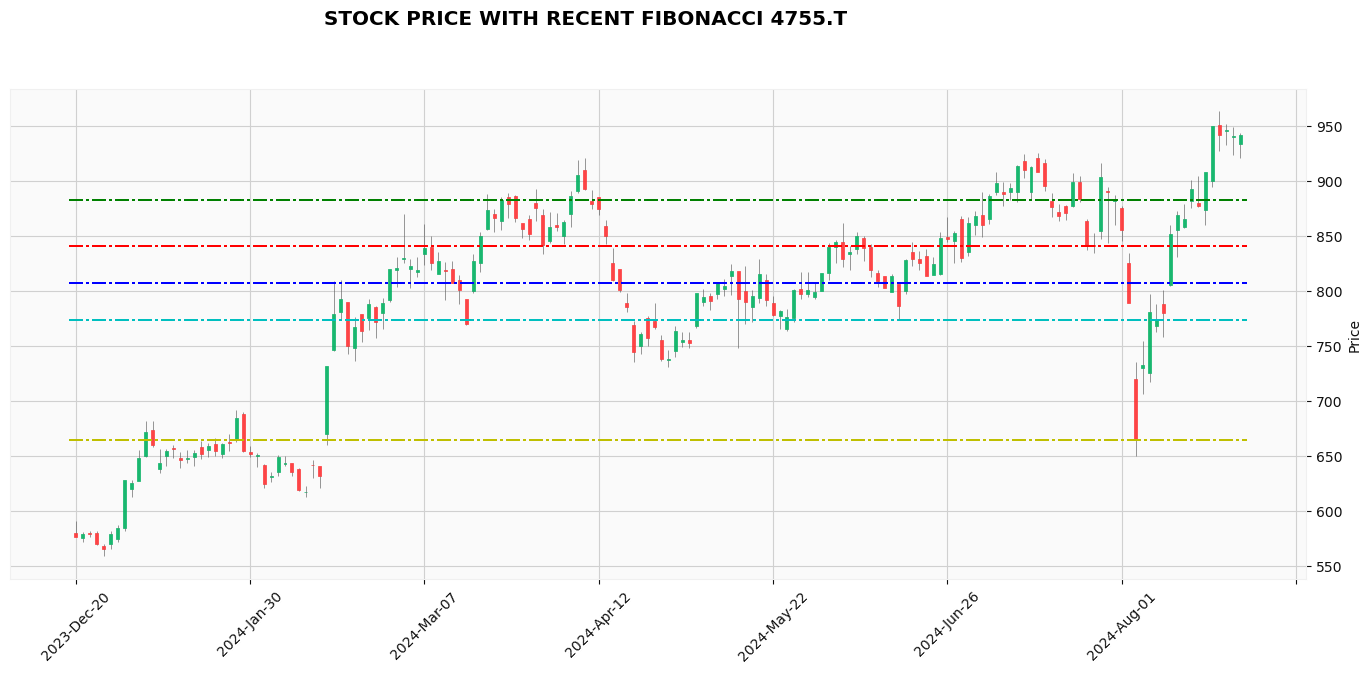

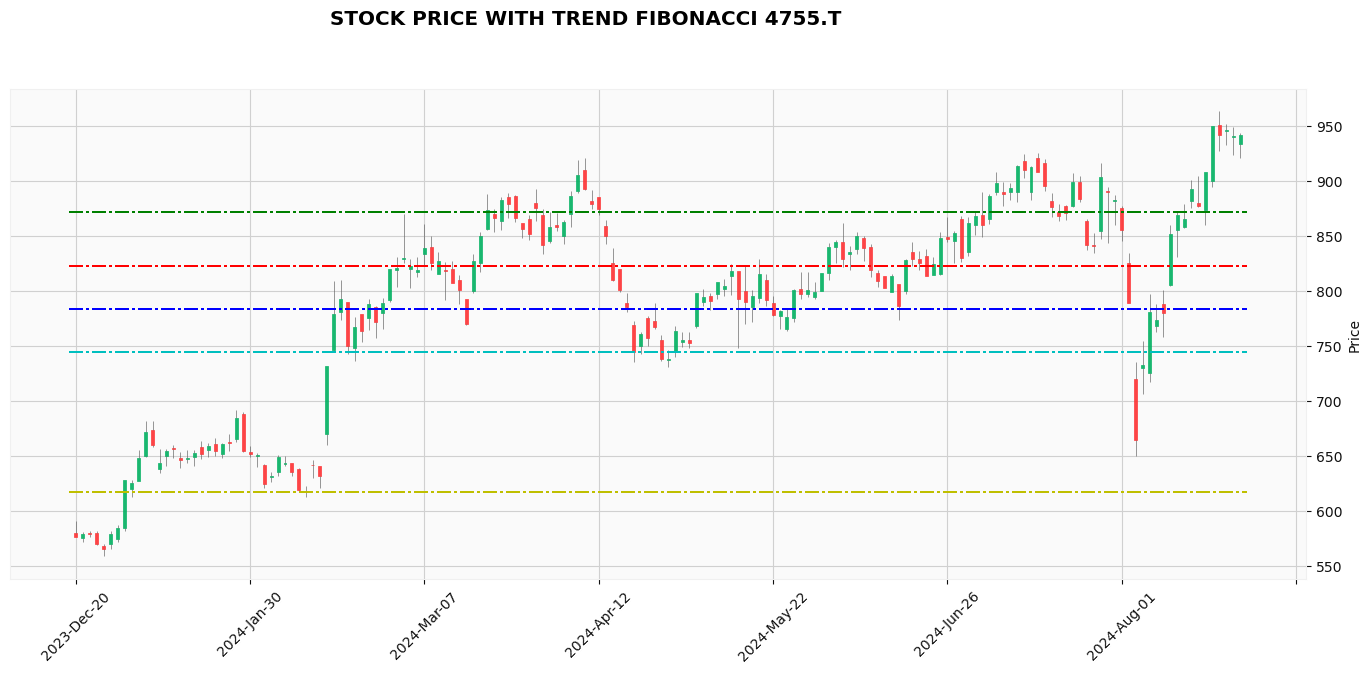

In [3]:
# 実行本体コード
def main(stock_symbol='4755.T', outlier_method='statistical', n_std=2, threshold=10, base_lookback=252):
    lookback_period = determine_lookback_period(stock_symbol, base_lookback)
    end_date = date.today()
    start_date = end_date - timedelta(days=base_lookback)
    data = yf.download(stock_symbol, start=start_date, end=end_date)
  
    short_window = int(lookback_period[0] / 4)
    long_window = int(lookback_period[0] / 2)
    data_with_ma = calculate_moving_averages(stock_symbol, data, short_window, long_window, base_lookback)

    if outlier_method == 'statistical':
        data_no_outliers = exclude_outliers_statistical(data_with_ma, n_std)
    elif outlier_method == 'percentage':
        data_no_outliers = exclude_outliers_percentage(data_with_ma, threshold)

    recent_high, recent_low = recent_highs_lows(data_no_outliers, long_window)
    fib_levels_recent = fibonacci_retracement_levels(recent_high, recent_low)

    trend_type, fib_levels_trend = trend_analysis(data_no_outliers)
    print(fib_levels_recent)
    print(fib_levels_trend)

    mpf.plot(data,type='candle',style='yahoo',figsize =(18,7),
          hlines=dict(hlines=list(fib_levels_recent.values()), colors=['g','r','b','c','y'],linestyle='-.'),
          title = "STOCK PRICE WITH RECENT FIBONACCI {0}".format(stock_symbol))

    mpf.plot(data,type='candle',style='yahoo',figsize =(18,7),
          hlines=dict(hlines=list(fib_levels_trend.values()), colors=['g','r','b','c','y'],linestyle='-.'),
          title = "STOCK PRICE WITH TREND FIBONACCI {0}".format(stock_symbol))

if __name__ == "__main__":
    main()